In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.style.use('../../paper.mcstyle')
import matplotlib.cm as cm

    
from scipy.stats import gaussian_kde


import pandas as pd
from sklearn.neighbors import NearestNeighbors

from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader, TorchLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from CNN import ConvNet
from CASBI.utils import create_template_library as ctl


In [2]:
if __name__ == '__main__':

    data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
    M_tot = 1.4*1e9
    alpha = 1.25
    test_set_sample = 100
    train_set_sample = 1_000
    

    #generate the input for the creation of the training and test template library 
    galaxy_name, mass_nn, infall_time, m_max, m_min = ctl.template_input(data, M_tot=1.4*1e9)
    
     
    #generate the test library
    flattened_hist_list_test, flattened_param_list_test, galaxies_test_name = ctl.gen_template_library(test_set_sample, galaxy_name, M_tot, mass_nn, infall_time, m_max, m_min, alpha)
    
    #generate the training library
    flattened_hist_list, flattened_param_list, galaxies_train_name = ctl.gen_template_library(train_set_sample, galaxy_name, M_tot, mass_nn, infall_time, m_max, m_min, alpha, galaxies_test_name)
   
    #rebalance the training set to avoid overfitting on high N
    mask = [flattened_hist_list[:, 1, 0, 0] < np.random.uniform(low=0, high=100, size=len(flattened_hist_list[:, 1, 0, 0])) ][0] 
    training_x = flattened_hist_list[mask]
    training_theta = flattened_param_list[mask]


unique galaxy in the test set that are not empty: 100
unique galaxy in the trainig set that are not empty: 997


In [4]:
test_x = torch.log1p(torch.from_numpy(flattened_hist_list_test)).float()
test_theta = torch.log10(torch.from_numpy(flattened_param_list_test)).float()

x = torch.log1p(torch.from_numpy(training_x)).float()
theta = torch.log10(torch.from_numpy(training_theta)).float()


gpu_index = 6  # replace with your desired GPU index
torch.cuda.set_device(gpu_index)
device = f"cuda:{gpu_index}"

conditions  = data[['star_log10mass', 'infall_time']]
minimum_theta = [np.log10(conditions[col].values.min()) for col in conditions.columns]   
maximum_theta = [np.log10(conditions[col].values.max()) for col in conditions.columns]    


def write_to_yaml(minimum_theta, maximum_theta, device):
    # Load the existing data
    with open('./training.yaml', 'r') as file:
        data = yaml.safe_load(file)
        
    # Update the value
    # data['prior']['args']['low'] = minimum_theta[0]
    # data['prior']['args']['high'] = maximum_theta[0]
    data['device'] = device

    # Write the data back to the file
    with open('./training.yaml', 'w') as file:
        yaml.safe_dump(data, file)
        
# write_to_yaml(minimum_theta, maximum_theta, device)
print('write the right prior in the training.yaml file')


write the right prior in the training.yaml file


In [5]:
class CustomDataset(Dataset):
    def __init__(self, observation, parameters, ):
        self.observation = observation
        self.parameters = parameters
        
        self.tensors = [self.observation, self.parameters]

    def __len__(self):
        return len(self.observation)

    def __getitem__(self, idx):
        observation = self.observation[idx].to('cuda') #this should put just the batch on the gpu
        parameters = self.parameters[idx].to('cuda')
        
        # observation = self.observation[idx] #this should put just the batch on the gpu
        # parameters = self.parameters[idx]

        return observation, parameters
    
    
# test_dataset = CustomDataset(x_0, theta_0)

# Split the original training dataset into a new training dataset and a validation dataset
# Here, we use 80% of the images for training and 20% for validation
# Assuming data and targets are your full dataset and labels
data_size = len(x)
print(data_size)    
indices = np.random.permutation(data_size)

# Decide on the split size, for example 80% for training and 20% for validation
split_idx = int(data_size * 0.8)

# Split the indices
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

# Create the data splits
train_data, train_targets = x[train_indices].float(), theta[train_indices].float()
val_data, val_targets = x[val_indices].float(), theta[val_indices].float(),

# Now you can create your DataLoaders
train_loader = torch.utils.data.DataLoader(CustomDataset(train_data.to('cuda'), train_targets.to('cuda'),), shuffle=True, batch_size=2024)
val_loader = torch.utils.data.DataLoader(CustomDataset(val_data.to('cuda'), val_targets.to('cuda'),), shuffle=False, batch_size=2024)
# test_loader = DataLoader(test_dataset,  shuffle=False)

loader = TorchLoader(train_loader=train_loader, val_loader=val_loader)
# runner = InferenceRunner.from_config(f"./training.yaml")

# define training arguments
train_args = {
    'training_batch_size': 1024,
    'learning_rate': 5e-5,
    'stop_after_epochs': 20
}

# instantiate a CNN embedding network
embedding_net =  ConvNet(output_dim=32).to('cuda')

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
                        embedding_net=embedding_net, x_normalize=False, device=device),
    # ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
    #                     embedding_net=embedding_net, x_normalize=False, device=device),
    # ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
    #                     embedding_net=embedding_net, x_normalize=False, device=device),
    # ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
    #                     embedding_net=embedding_net, x_normalize=False, device=device),
]

prior = ili.utils.Uniform(low=minimum_theta, high=maximum_theta, device=device)

    # initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir='./',
)

posterior_ensemble, summaries = runner(loader=loader,)



34980


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
390 epochs [15:32,  2.39s/ epochs, loss=-0.806, loss_val=-0.674] 
INFO:root:It took 934.2009954452515 seconds to train models.
INFO:root:Saving model to .


In [7]:
#paper column width is 397.48499pt
pt = 1/72.27
column_width = 397.48499*pt
aspect_ratio = 1.61803398875
my_width = column_width
my_height = my_width/aspect_ratio


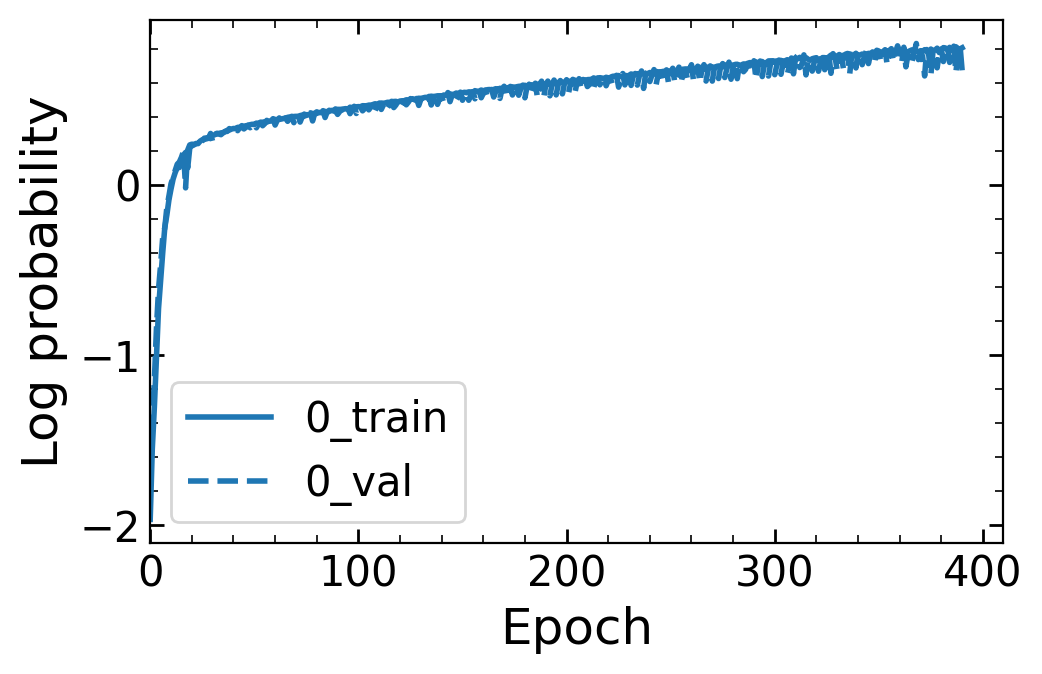

In [8]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
fig.savefig('./train_val_loss.png')

/tmp/ipykernel_439242/3619645580.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name


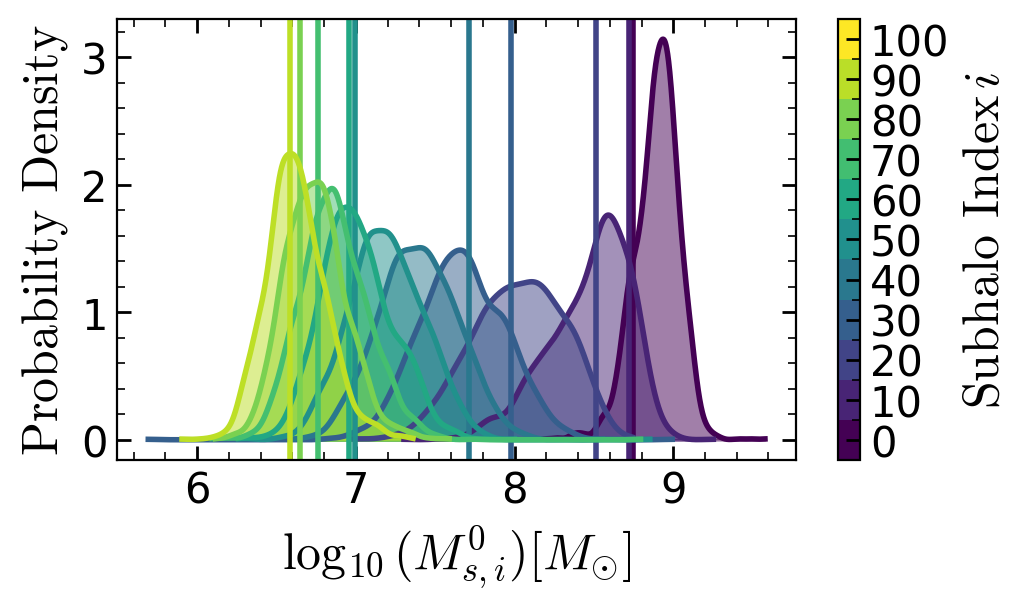

In [9]:

# Create a colormap
cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name

# Create a list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 11)]  # Replace 10 with the number of colors you want

fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
for (c,i) in enumerate(range(10)):
    samples = posterior_ensemble.sample((2_001,), x=test_x[i].unsqueeze(0).to(device), show_progress_bars=False) 
    samples =  samples[:, 0].cpu().numpy()
    density = gaussian_kde(samples)
    density_val = density(np.linspace(min(samples), max(samples), 1000))
    ax.plot(np.linspace(min(samples), max(samples), 1000), density_val, color=colors[c])    
    ax.fill_between(np.linspace(min(samples), max(samples), 1000), density_val, alpha=0.5, color=colors[c])
    ax.axvline(x=test_theta[i][0].cpu().numpy(), color=colors[c])

ax.set_xlabel(r'$\log_{10}(M_{s,i}^0) [M_{\odot}]$')
ax.set_ylabel(r'$\text{Probability Density}$')


norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 11, 1), ncolors=cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(11))
cbar.ax.set_yticklabels([f'{i*10}' for i in range(11)])  # Set the labels for the colorbar
cbar.set_label(r'$\text{Subhalo Index} \, i$')
fig.tight_layout()
# ax.set_xscale('log')
plt.savefig('./posterior.pdf')
